In [1]:
import keras
from keras.layers import LSTM, Activation, Dense, BatchNormalization 
from keras.layers import TimeDistributed, SeparableConv2D, Conv2D, Input, Reshape, ConvLSTM2D
from keras import backend as K
from keras.applications.mobilenet import DepthwiseConv2D
import numpy as np


def relu6(x):
    return K.relu(x, max_value=6)

def _depthwise_conv_block_TimeDistributed(model, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):
    """this is rewritten from keras.applications.mobilenet, 
    using ConvLSTM2D and TimeDistributed depthwise convolution
    Adds a depthwise convolution block.
    
    A depthwise convolution block consists of a depthwise conv,
    batch normalization, relu6, pointwise convolution,
    batch normalization and relu6 activation.
    # Arguments
        inputs: Input tensor of shape `(rows, cols, channels)`
            (with `channels_last` data format) or
            (channels, rows, cols) (with `channels_first` data format).
        pointwise_conv_filters: Integer, the dimensionality of the output space
            (i.e. the number output of filters in the pointwise convolution).
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        depth_multiplier: The number of depthwise convolution output channels
            for each input channel.
            The total number of depthwise convolution output
            channels will be equal to `filters_in * depth_multiplier`.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
        block_id: Integer, a unique identification designating the block number.
    # Input shape
        4D tensor with shape:
        `(batch, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(batch, filters, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, new_rows, new_cols, filters)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.
    # Returns
        Output tensor of block.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)
    
#     #################
#     model.add(ConvLSTM2D(filters=filtnum, kernel_size=(3, 3),
#                    input_shape=(150, 64, 128, 1),
#                    padding='same', return_sequences=True))
#     model.add(BatchNormalization())
#     model.add(MaxPooling3D(pool_size=(1, 4, 4), padding='valid'))
#     #############
    
    model.add(TimeDistributed(DepthwiseConv2D((3, 3),
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False),
                        name='conv_dw_%d' % block_id))
    model.add(TimeDistributed(BatchNormalization(axis=channel_axis), name='conv_dw_%d_bn' % block_id))
    model.add(TimeDistributed(Activation(relu6), name='conv_dw_%d_relu' % block_id))

    model.add(ConvLSTM2D(pointwise_conv_filters, (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1),
               return_sequences=True,
               name='conv_pw_%d' % block_id))
    model.add(BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id))
    model.add(Activation(relu6, name='conv_pw_%d_relu' % block_id))
    return model

# keras.layers.ConvLSTM2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, return_sequences=False, go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0)

alpha = 0.25 # alpha must be something like 1, .75, .5, .25
depth_multiplier = 1
channel_axis = 'channels_first'
start_filters = int(32*alpha*2)
input_shape = (150,64,128,1)
output_shape = (150,54)


model = keras.models.Sequential()
# model.add(ConvLSTM2D(start_filters, (3,3), return_sequences=True, padding='same' , strides=(2,2), input_shape=input_shape ))
model.add(TimeDistributed(Conv2D(start_filters, (3,3), padding='same' , strides=(2,2)), input_shape=input_shape ))
_depthwise_conv_block_TimeDistributed(model, 64, alpha, depth_multiplier, block_id=1)

_depthwise_conv_block_TimeDistributed(model, 128, alpha, depth_multiplier,
                          strides=(2, 2), block_id=2)
_depthwise_conv_block_TimeDistributed(model, 128, alpha, depth_multiplier, block_id=3)

_depthwise_conv_block_TimeDistributed(model, 256, alpha, depth_multiplier,
                          strides=(2, 2), block_id=4)
_depthwise_conv_block_TimeDistributed(model, 256, alpha, depth_multiplier, block_id=5)

_depthwise_conv_block_TimeDistributed(model, 512, alpha, depth_multiplier,
                          strides=(2, 2), block_id=6)
_depthwise_conv_block_TimeDistributed(model, 512, alpha, depth_multiplier, block_id=7)
_depthwise_conv_block_TimeDistributed(model, 512, alpha, depth_multiplier, block_id=8)
_depthwise_conv_block_TimeDistributed(model, 512, alpha, depth_multiplier, block_id=9)
_depthwise_conv_block_TimeDistributed(model, 512, alpha, depth_multiplier, block_id=10)
_depthwise_conv_block_TimeDistributed(model, 512, alpha, depth_multiplier, block_id=11)

_depthwise_conv_block_TimeDistributed(model, 1024, alpha, depth_multiplier,
                          strides=(2, 2), block_id=12)
_depthwise_conv_block_TimeDistributed(model, 1024, alpha, depth_multiplier, block_id=13)

model.add(Reshape((output_shape[0],-1)))
model.add(LSTM(output_shape[1], return_sequences=True))
model.add(BatchNormalization(momentum=0))
model.add(Activation('softplus'))




#     model = Sequential()
#     _conv_block(model,input_shape, 32, alpha, strides=(2, 2))
#     model.summary()



#     if include_top:
#         if K.image_data_format() == 'channels_first':
#             shape = (int(1024 * alpha), 1, 1)
#         else:
#             shape = (1, 1, int(1024 * alpha))

#         x = GlobalAveragePooling2D()(x)
#         x = Reshape(shape, name='reshape_1')(x)
#         x = Dropout(dropout, name='dropout')(x)
#         x = Conv2D(classes, (1, 1),
#                    padding='same', name='conv_preds')(x)
#         x = Activation('softmax', name='act_softmax')(x)
#         x = Reshape((classes,), name='reshape_2')(x)
#     else:
#         if pooling == 'avg':
#             x = GlobalAveragePooling2D()(x)
#         elif pooling == 'max':
#             x = GlobalMaxPooling2D()(x)

#     # Ensure that the model takes into account
#     # any potential predecessors of `input_tensor`.
#     if input_tensor is not None:
#         inputs = get_source_inputs(input_tensor)
#     else:
#         inputs = img_input



adamopt = keras.optimizers.Adam(lr = 0.005, decay = 5e-7)
# Please make sure to use Poisson likelihood function for the loss function
model.compile(optimizer=adamopt, loss='poisson')
model.summary()

# save the model architechture 
model_json = model.to_json()
with open("conv_lstm_mobilenet_model_arch.json", "w") as json_file:
    json_file.write(model_json)


Using TensorFlow backend.
/Users/dclark/.virtualenvs/keras_tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 150, 32, 64, 16)   160       
_________________________________________________________________
conv_dw_1 (TimeDistributed)  (None, 150, 32, 64, 16)   144       
_________________________________________________________________
conv_dw_1_bn (TimeDistribute (None, 150, 32, 64, 16)   64        
_________________________________________________________________
conv_dw_1_relu (TimeDistribu (None, 150, 32, 64, 16)   0         
_________________________________________________________________
conv_pw_1 (ConvLSTM2D)       (None, 150, 32, 64, 16)   2048      
_________________________________________________________________
conv_pw_1_bn (BatchNormaliza (None, 150, 32, 64, 16)   64        
_________________________________________________________________
conv_pw_1_relu (Activation)  (None, 150, 32, 64, 16)   0         
__________

In [2]:
# Template for the SMC competition for modeling neurons in the superior colliculus

import numpy as np
import h5py

# Please download the file SCNeuronModelCompetition.mat from here.
# https://github.com/santacruzml/fall-17-scml-competition/releases/download/0.0-data/SCNeuronModelCompetition.mat

datafile = h5py.File('SCNeuronModelCompetition.mat')
movie = datafile.get('trainingmovie_mini') # movie for training
frhist = datafile.get('FRhist_tr') # firing rate histograms

def preprocess_movie(movie_in):
    # trim the letterbox from the video
    movie_out = np.array(movie_in[:,:,(16*128):(80*128)],dtype=np.uint8)
    # reshape to original video frames
    movie_out = np.reshape(movie_out,(288,150,64,128,1))
    return movie_out

movie = preprocess_movie(movie)



In [3]:
filepath = 'conv_lstm_mobilenet_checkpoint.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, period=2)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(movie, frhist, epochs=200, batch_size=4, validation_split=0.2, shuffle=True, callbacks=[early_stopping, checkpoint])



Train on 230 samples, validate on 58 samples
Epoch 1/200
230/230 [==============================] - 282s 1s/step - loss: 0.7124 - val_loss: 0.6609
Epoch 2/200
230/230 [==============================] - 263s 1s/step - loss: 0.6129 - val_loss: 0.5750
Epoch 3/200
230/230 [==============================] - 259s 1s/step - loss: 0.5452 - val_loss: 0.5175
Epoch 4/200
230/230 [==============================] - 260s 1s/step - loss: 0.4957 - val_loss: 0.4756
Epoch 5/200
230/230 [==============================] - 259s 1s/step - loss: 0.4597 - val_loss: 0.4451
Epoch 6/200
230/230 [==============================] - 259s 1s/step - loss: 0.4334 - val_loss: 0.4226
Epoch 7/200
230/230 [==============================] - 259s 1s/step - loss: 0.4140 - val_loss: 0.4059
Epoch 8/200
230/230 [==============================] - 260s 1s/step - loss: 0.3994 - val_loss: 0.3933
Epoch 9/200
230/230 [==============================] - 259s 1s/step - loss: 0.3883 - val_loss: 0.3835
Epoch 10/200
230/230 [===============

KeyboardInterrupt: 

In [ ]:
model.save('conv_lstm_mobilenet_model.h5')

In [7]:
model.load_weights(filepath)

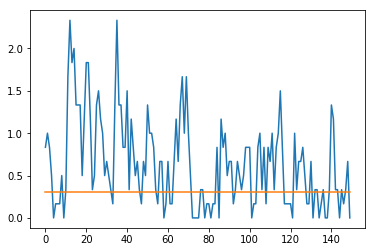

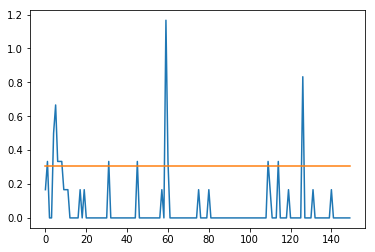

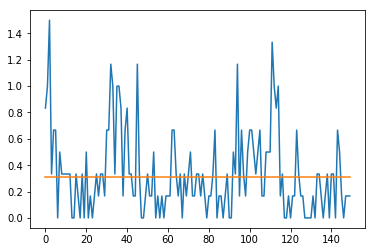

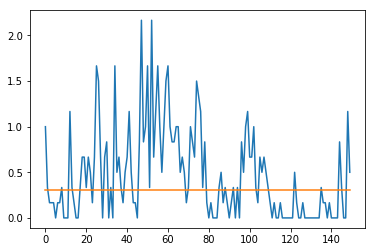

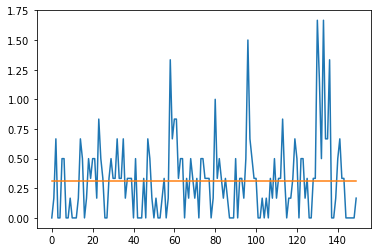

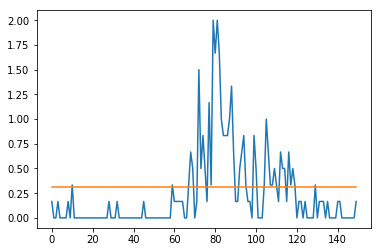

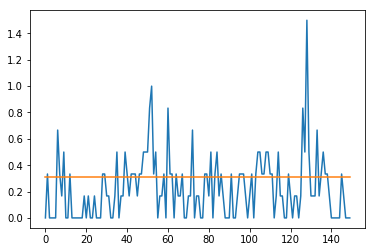

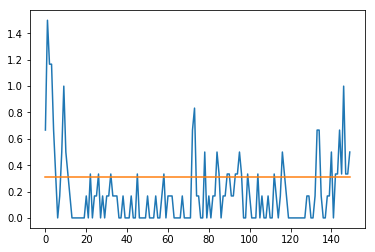

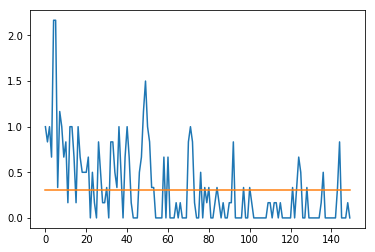

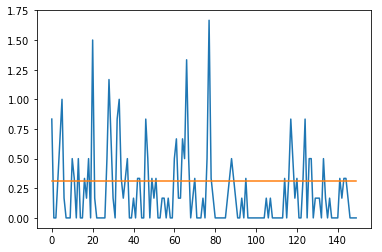

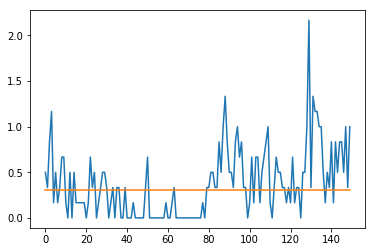

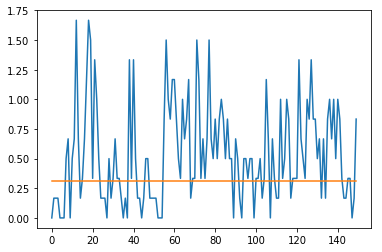

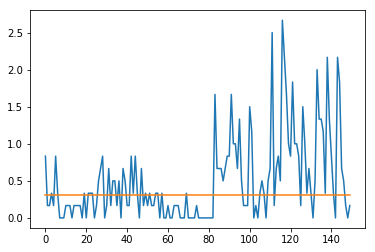

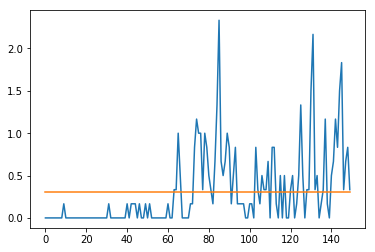

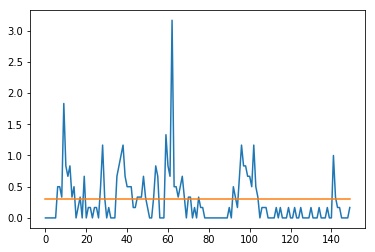

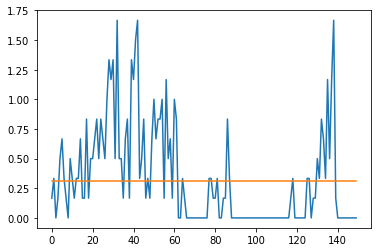

KeyboardInterrupt: 

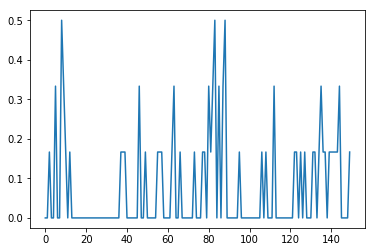

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

for m in range(0, 48):
    n=31
    # plot the average of 6 trials of the same movie
    plt.plot(np.mean(frhist[(m*6):(m+1)*6, :, n], axis=(0)))

    
    # plot the output of the network
    # plt.plot(output[m*6,:,n])
    output = model.predict(movie[(m*6):(m+1)*6,:,:,:])
    plt.plot(np.mean(output[:, :, n], axis=(0)))
    plt.show()
    # last 10 movies should be the validation dataset

In [3]:
model.load_weights('conv_lstm_mobilenet_checkpoint.h5')


In [46]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# layer_output = layer_dict['time_distributed_1'].output
# weights = layer_dict['time_distributed_1'].get_weights()
weights = model.layers[4].get_weights()

In [47]:
# filter_index = 0
# fout = layer_output[:, :, :, filter_index]

In [48]:
weights = np.squeeze(weights)

In [49]:
weights.shape

(2, 16, 64)

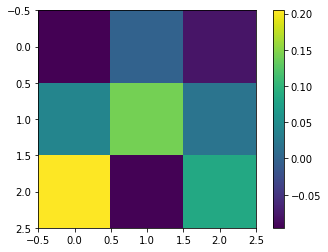

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

f = np.squeeze(weights[0][:,:,0,2])

plt.imshow(f)
plt.colorbar()

In [21]:
layer_dict['time_distributed_1'].get_config()

{'batch_input_shape': (None, 150, 64, 128, 1),
 'dtype': 'float32',
 'layer': {'class_name': 'Conv2D',
  'config': {'activation': 'linear',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'filters': 16,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (3, 3),
   'name': 'conv2d_1',
   'padding': 'same',
   'strides': (2, 2),
   'trainable': True,
   'use_bias': True}},
 'name': 'time_distributed_1',
 'trainable': True}